In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import segmentation_models_pytorch as smp


In [3]:
class RoadSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images_list = sorted(os.listdir(images_dir))
        self.masks_list = sorted(os.listdir(masks_dir))
        
    def __len__(self):
        return len(self.images_list)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        mask = (mask > 0).float()  # Konwersja maski do wartości binarnych
        #mask = torch.from_numpy(mask).unsqueeze(0)  # Dodaj wymiar kanału
        
        return image, mask


In [4]:
class DiceLoss(torch.nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()
    
    def forward(self, inputs, targets, smooth=1):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice


In [5]:

data_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_images_dir = 'tiff/train'
train_masks_dir = 'tiff/train_labels'

val_images_dir = 'tiff/val'
val_masks_dir = 'tiff/val_labels'

test_images_dir = 'tiff/test'
test_masks_dir = 'tiff/test_labels'


train_dataset = RoadSegmentationDataset(train_images_dir, train_masks_dir, transform=data_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = RoadSegmentationDataset(val_images_dir, val_masks_dir, transform=data_transforms)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

test_dataset = RoadSegmentationDataset(test_images_dir, test_masks_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)


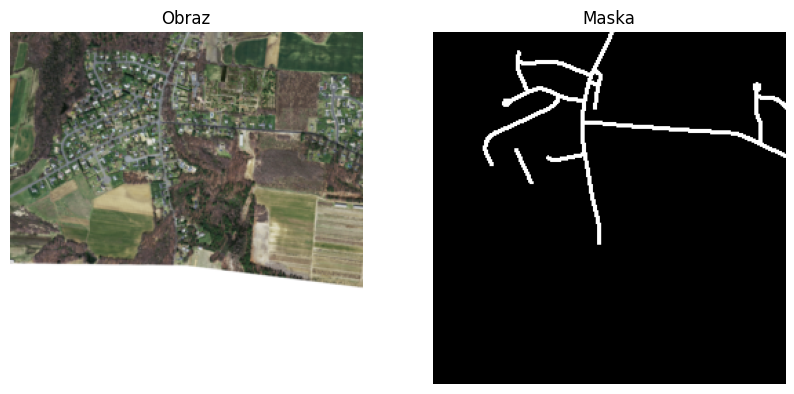

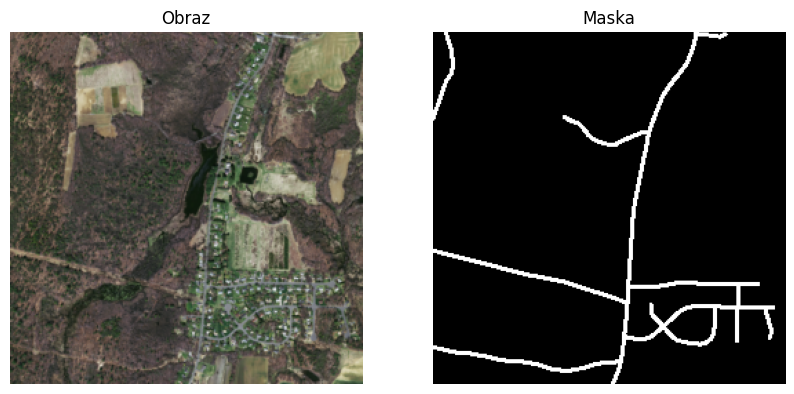

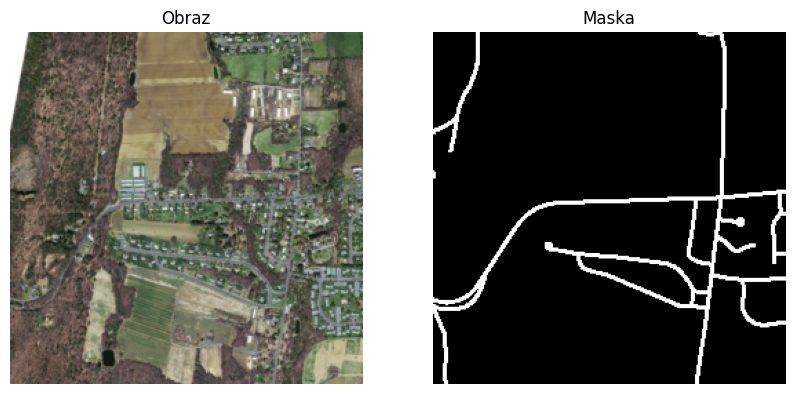

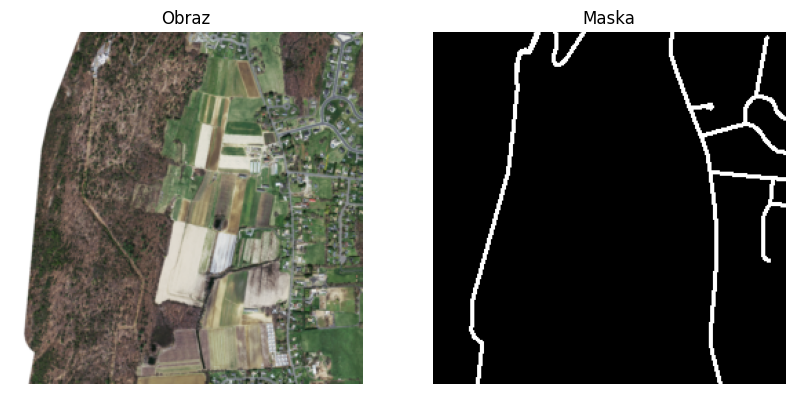

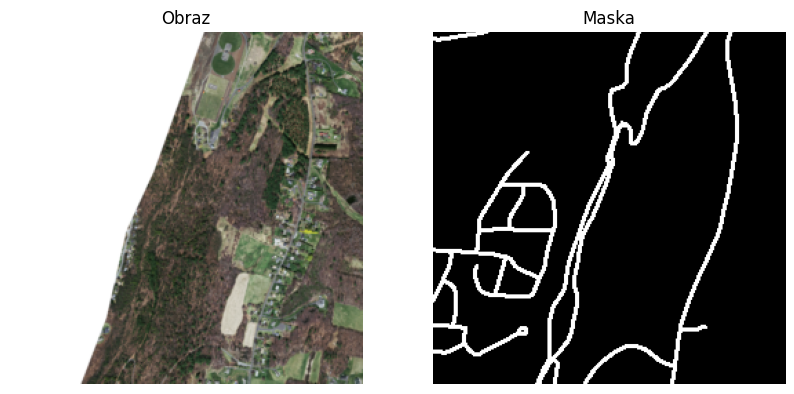

In [6]:
def visualize_samples(dataset, num_samples=5):
    for i in range(num_samples):
        image, mask = dataset[i]
        image_np = image.permute(1, 2, 0).numpy()
        mask_np = mask.squeeze(0).numpy()

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image_np)
        axs[0].set_title('Obraz')
        axs[0].axis('off')
        axs[1].imshow(mask_np, cmap='gray')
        axs[1].set_title('Maska')
        axs[1].axis('off')
        plt.show()


visualize_samples(train_dataset, num_samples=5)


In [7]:
model = smp.Unet(
    encoder_name='resnet34',       
    encoder_weights='imagenet',     
    in_channels=3,                  
    classes=1,                     
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

device

device(type='cuda')

In [8]:

#criterion = torch.nn.BCEWithLogitsLoss()
criterion = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [9]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        #outputs = outputs.squeeze(1)  # Adjusting dimensions if necessary
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Calculate the average loss for this epoch's training
    train_loss /= len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            
            val_outputs = model(val_images)
            #val_outputs = val_outputs.squeeze(1)  # Adjusting dimensions if necessary
            
            loss = criterion(val_outputs, val_masks)
            val_loss += loss.item()

        # Calculate the average loss for the validation set
        val_loss /= len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")


Epoch [1/50], Train Loss: 0.6798
Epoch [1/50], Validation Loss: 0.7187
Epoch [2/50], Train Loss: 0.5506
Epoch [2/50], Validation Loss: 0.5791
Epoch [3/50], Train Loss: 0.4729
Epoch [3/50], Validation Loss: 0.4764
Epoch [4/50], Train Loss: 0.4155
Epoch [4/50], Validation Loss: 0.3872
Epoch [5/50], Train Loss: 0.3871
Epoch [5/50], Validation Loss: 0.3579
Epoch [6/50], Train Loss: 0.3648
Epoch [6/50], Validation Loss: 0.3457
Epoch [7/50], Train Loss: 0.3395
Epoch [7/50], Validation Loss: 0.3194
Epoch [8/50], Train Loss: 0.3217
Epoch [8/50], Validation Loss: 0.3204
Epoch [9/50], Train Loss: 0.3063
Epoch [9/50], Validation Loss: 0.3117
Epoch [10/50], Train Loss: 0.3037
Epoch [10/50], Validation Loss: 0.3088
Epoch [11/50], Train Loss: 0.2950
Epoch [11/50], Validation Loss: 0.2801
Epoch [12/50], Train Loss: 0.2830
Epoch [12/50], Validation Loss: 0.3126
Epoch [13/50], Train Loss: 0.2778
Epoch [13/50], Validation Loss: 0.2991
Epoch [14/50], Train Loss: 0.2745
Epoch [14/50], Validation Loss: 0.2

KeyboardInterrupt: 

In [ ]:
def iou_score(output, target):
    smooth = 1e-6
    output = torch.sigmoid(output)  # Applying sigmoid to get probabilities
    output = (output > 0.5).int()   # Thresholding probabilities to create a binary mask

    if output.dtype != target.dtype:
        target = target.int()  # Ensuring target is also an int type

    intersection = (output & target).sum((1, 2))  # Performing bitwise AND operation
    union = (output | target).sum((1, 2))         # Performing bitwise OR operation

    iou = (intersection + smooth) / (union + smooth)
    return iou.mean()  # or return the whole array

def dice_score(output, target):
    smooth = 1e-6
    output = torch.sigmoid(output)
    output = (output > 0.5).int()

    if output.dtype != target.dtype:
        target = target.int()  # Ensuring target is also an int type

    intersection = (output & target).sum((1, 2))
    dice = (2. * intersection + smooth) / (output.sum((1, 2)) + target.sum((1, 2)) + smooth)
    return dice.mean()  # or return the whole array


model.eval()
test_loss = 0
iou_scores = []
dice_scores = []

with torch.no_grad():
    for test_images, test_masks in test_loader:
        test_images = test_images.to(device)
        test_masks = test_masks.to(device)

        test_outputs = model(test_images)
        # test_outputs = test_outputs.squeeze(1)  # Adjusting dimensions if necessary

        loss = criterion(test_outputs, test_masks)
        test_loss += loss.item()

        # Compute IoU and Dice scores
        iou_scores.append(iou_score(test_outputs, test_masks))
        dice_scores.append(dice_score(test_outputs, test_masks))

# Average testing loss
test_loss /= len(test_loader)
average_iou = sum(iou_scores) / len(iou_scores)
average_dice = sum(dice_scores) / len(dice_scores)

print(f"Test Loss: {test_loss:.4f}")
print(f"Average IoU: {average_iou:.4f}")
print(f"Average Dice Score: {average_dice:.4f}")


Test Loss: 0.2538
Average IoU: 0.6119
Average Dice Score: 0.7292
